In this notebook, we aim to recover the convergence map $\kappa$ from the observed shear $\gamma$.

The shear map can be obtained by the Kaiser-Squires transformation: $\gamma = \mathrm{TFP}^* \kappa$, where 

<ul>
    <li>$\mathrm{T}$ is a Non-equispaced Discrete Fourier Transform, so not necessiraly invertible,</li>
    <li>$\mathrm{P}$ is a diagonal operator, implementing the transformation from convergence to shear in Fourier space,</li>
    <li>$\mathrm{F}$ is the Fourier matrix.</li>
</ul>

Since this transformation is not always invertible, we recover the convergence map $\kappa$ by maximum likelihood:

$\begin{aligned}
\kappa &= \underset{\kappa}{\operatorname{argmax}} p(\gamma|\kappa)
\end{aligned}$

Here, we supppose that we observe the shear $\gamma$ as the Kaise-Squires transformation of the convergence $\kappa$ comtaminated by an additive gaussian noise $n\sim \mathcal{N}(0, \bf{I})$. Then, $\gamma \sim \mathcal{N}(\mathrm{TPF}^*\kappa, \bf{I})$ and

$\begin{aligned}
\kappa &= \underset{\kappa}{\operatorname{argmax}} \dfrac{1}{(2\pi)^{N/2}} \exp \left(-\frac{1}{2}\|\gamma - \mathrm{TFP}^* \kappa\|_2^2 \right) \\
        &= \underset{\kappa}{\operatorname{argmin}} \|\gamma - \mathrm{TFP}^* \kappa\|_2^2
\end{aligned}$.

We can also add a regulizer to this likelihood as a $\ell_2$-norm on the convergence (corresponding to a gaussian prior) or a $\ell_1$-norm to enforce sparcity.

Enventally, the convergence maps are obtained by minimizing these criteria with a stochastic gradient descent.

In [1]:
import matplotlib.pyplot as plt

from lenspack.utils import bin2d
from lenspack.peaks import find_peaks2d

import jax_lensing

from jax_lensing.inversion import ks93
from jax_lensing.inverse_problem import gamma2kappa, square_norm, square_norm_smooth, square_norm_sparse

from astropy.table import Table

In [2]:
def plot_convergence(kappaE, x, y, title=''):
    # Plot peak positions over the convergence
    fig, ax = plt.subplots(1, 1, figsize=(7, 5.5))
    mappable = ax.imshow(kappaE, origin='lower', cmap='bone')
    ax.scatter(y, x, s=10, c='orange')  # reverse x and y due to array indexing
    ax.set_axis_off()
    fig.colorbar(mappable)
    plt.title(title)

In [3]:
# Import the galaxy catalog
cat = Table.read('../data/gal_cat.fits')

# Bin ellipticity components based on galaxy position into a 128 x 128 map
e1map, e2map = bin2d(cat['ra'], cat['dec'], v=(-cat['gamma1'], -cat['gamma2']), npix=128)

**Recover the convergence via Kaiser-Squires inversion**

/opt/anaconda3/envs/cosmo/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


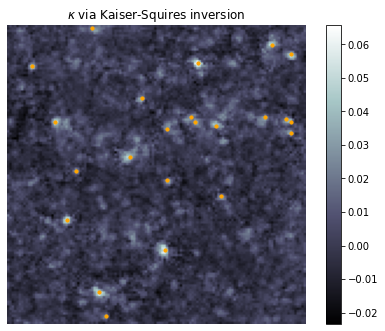

In [4]:
# Recover convergence via Kaiser-Squires inversion
kappaE, kappaB = ks93(e1map, e2map)

x, y, h = find_peaks2d(kappaE, threshold=0.03, include_border=True)

# Plot peak positions over the convergence
plot_convergence(kappaE, x, y, title='$\kappa$ via Kaiser-Squires inversion')

plt.show()

**Recover the convergence via minimizing the following objective function:**
$$\|\gamma - \mathrm{TFP}^* \kappa\|_2^2$$
where $\mathrm{TFP}^*$ corresponds to the Kaiser-Squires transformation.

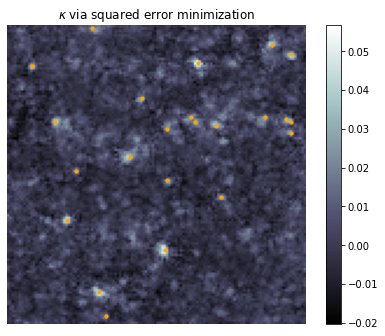

In [5]:
# Recover convergence minimizing the squared error
kEhat, kBhat = gamma2kappa(e1map, e2map, obj=square_norm, kappa_shape=kappaE.shape)

x, y, h = find_peaks2d(kappaE, threshold=0.03, include_border=True)

plot_convergence(kEhat, x, y, title='$\kappa$ via squared error minimization')

**With a *smooth* regularisation:**
$$\|\gamma - \mathrm{TFP}^* \kappa\|_2^2 + \lambda \|\kappa\|_2^2$$
where $\mathrm{TFP}^*$ corresponds to the Kaiser-Squires transformation.

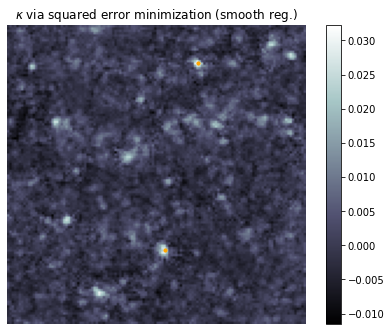

In [6]:
# Recover convergence minimizing the squared error with smooth regularization
kEhat, kBhat = gamma2kappa(e1map, e2map, obj=square_norm_smooth, kappa_shape=kappaE.shape)

x, y, h = find_peaks2d(kEhat, threshold=0.03, include_border=True)

# Plot peak positions over the convergence
plot_convergence(kEhat, x, y, title='$\kappa$ via squared error minimization (smooth reg.)')

**With a *sparse* regularisation:**
$$\|\gamma - \mathrm{TFP}^* \kappa\|_2^2 + \lambda \|\kappa\|_1$$
where $\mathrm{TFP}^*$ corresponds to the Kaiser-Squires transformation.

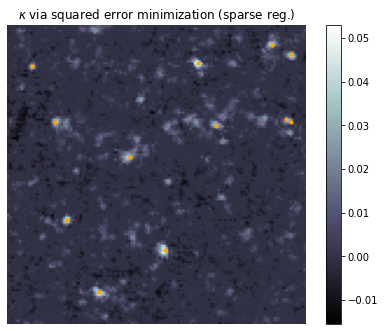

In [7]:
# Recover convergence minimizing the squared error with sparse regularization
kEhat, kBhat = gamma2kappa(e1map, e2map, obj=square_norm_sparse, kappa_shape=kappaE.shape)

x, y, h = find_peaks2d(kEhat, threshold=0.03, include_border=True)

# Plot peak positions over the convergence
plot_convergence(kEhat, x, y, title='$\kappa$ via squared error minimization (sparse reg.)')